# Heart failure prediction with artificial intelligence

This notebook has been created by the Vicomtech team:


*   **Author:** Ander Cejudo (email: acejudo@vicomtech.org)
*   **Reviewer:** María Jesús García (email: mjgarcia@vicomtech.org)



## 1. Introduction

The objective of this notebook is to load a dataset from [kaggle](https://www.kaggle.com/code/jamessdev/heart-failure-classification-algorithms/notebook) in order to:


*   Make an **exploratory analysis** of the data
*   Predict if the risk of heart failure of a given subject



The steps are described in the following image.


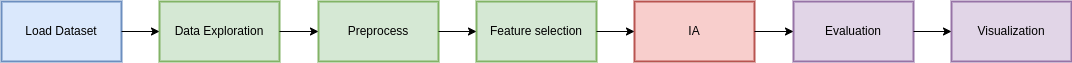

# 2. Requirements

In this step the required python packages will be loaded, having a description for each of the packages.

In [45]:
!pip install shap

In [46]:
# Others
import os
import random

# Data treatment
import numpy
import pandas as pd

# Visualization
import seaborn
import matplotlib.pyplot as plt

# Preprocess
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split

# Machine learning classifiers
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Deep learning
import keras
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense, Input, Dropout
import tensorflow as tf
from tensorflow.python.keras import backend as K

# Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay

# Visualization / Sensitivity
import shap
from sklearn.tree import export_graphviz
from tensorflow.keras.utils import plot_model


# For reproducibility
numpy.random.seed(16)
os.environ['PYTHONHASHSEED'] = str(545)
random.seed("23")
keras.utils.set_random_seed(565)
tf.random.set_seed(123)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)



## 3. Load dataset

In this step wi will download the dataset from [kaggle](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) and load it in a pandas DataFrame. The dataset has been added into the colab environment as "heart.csv". A CSV stores values separated with commas, where a row is an example of the data and each column represents a feature of the data.

Make sure that you have the "heart.csv" in your environment, otherwise download the file from kaggle and put it as in the image.
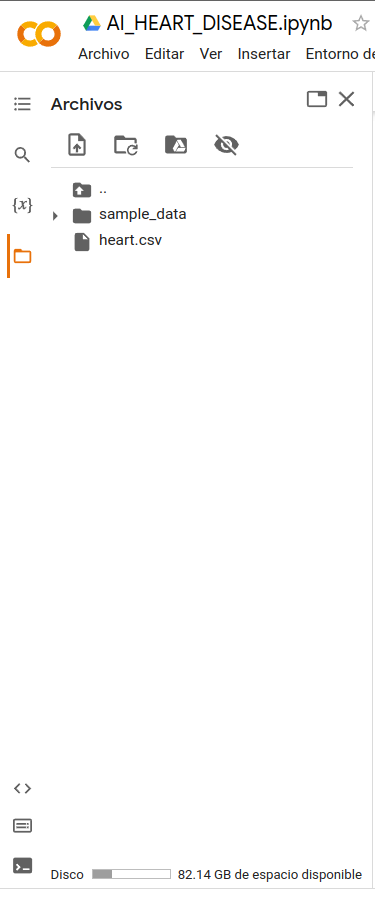



In [47]:
# Load the csv file
df = pd.read_csv('heart.csv')
# Print the file
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


As it can be seen in at the bottom of the table, there are:

*   918 examples (rows)
*   12 columns (features)



A row represents an observation and a feature represents a variable that describes the observation. In this case, each row represents the data gathered from a patient.  

# 4. Data Exploration

In this step, the objective is to get familiar with the dataset and see which are the features and what values are stored in them. Mainly, there are 2 types of features:



*   **Categorical:** limited set of possible values (e.g. Sex)
*   **Number** (e.g. Cholesterol)






Pandas includes a method to describe each column of the dataframe:

In [48]:
df["Sex"].describe()

count     918
unique      2
top         M
freq      725
Name: Sex, dtype: object

Taking the variable type into account different visualizations can be proposed, where each visualization can be univariate (i.e. using only one variable), bivariate (i.e. using two variables) or even with more variables.

In [49]:
# HeartDisease is categorical because the possible values are 0 or 1, but pandas understands it as numerical
# Convert it to categorical
df["HeartDisease"] = df["HeartDisease"].astype("category")

<Axes: xlabel='Sex', ylabel='Count'>

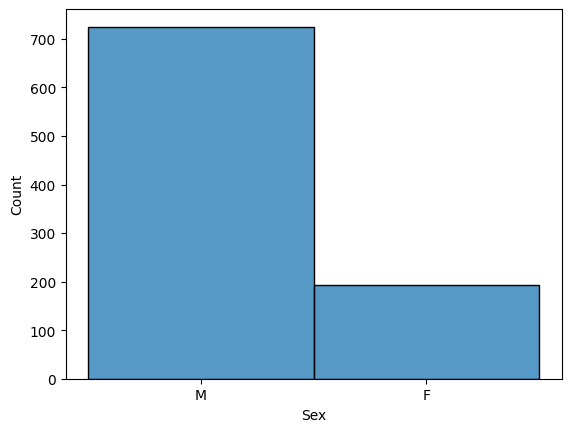

In [50]:
# Number of Male VS Female (Univariate)
seaborn.histplot(data=df, x="Sex")

<Axes: xlabel='HeartDisease', ylabel='Age'>

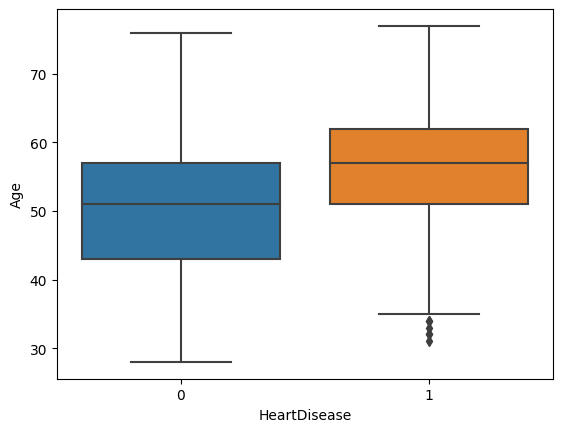

In [51]:
# Age and heart disease (Bivariate)
seaborn.boxplot(data=df, x="HeartDisease", y="Age")

<Axes: xlabel='HeartDisease', ylabel='Count'>

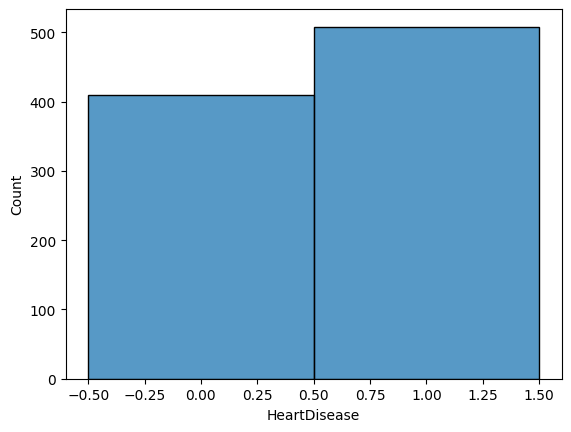

In [52]:
# Apart from the count of the people with and without heart disease, we can see that the class (i.e. HeartDisease) is balanced.
# That is, not much difference between the two posible values (i.e. 0 or 1)
seaborn.histplot(data=df, x="HeartDisease")

We can also do a multivariate plot, to see the correlation in this case between having a disease, the age of the subject and their max heart rate. We can see that is older and has a lower maximum heart rate, may be more likely to have a heart disease.

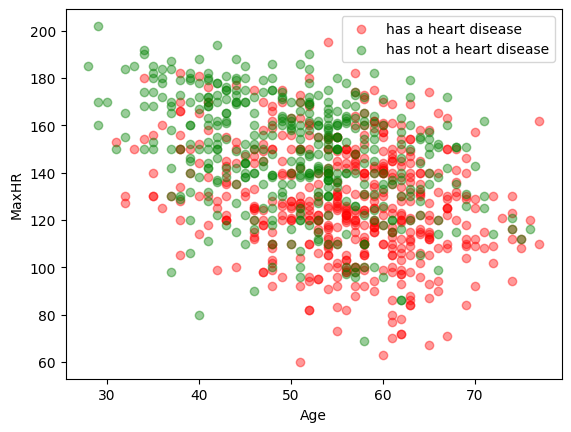

In [53]:

# yes = heart disease, no = has not a heart disease
yes = df[df.HeartDisease == 1]
no = df[df.HeartDisease == 0]

# Compare of Age and MaxHR
plt.scatter(yes.Age,yes.MaxHR,color='red',label='has a heart disease',alpha=0.4)
plt.scatter(no.Age,no.MaxHR,color='green',label='has not a heart disease',alpha=0.4)
plt.xlabel("Age")
plt.ylabel("MaxHR")
plt.legend()
plt.show()

Apart from visualization, sometimes, some values may be missing. In this case, all the data is complete.

In [54]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

## 4. Preprocessing

In order to predict whether a subject may have a heart disease, all the data must be transformed to a numeric value. In the case of categorical variables, there are two main options to preprocess:



1.   Convert each possible value to a number (for example, 0 for male and 1 for female).
2.   Convert each possible value into a column, for example


> *   Replace Sex with a column for "Male" and a column for "Female", with a 1 in the corresponding sex of the subject.
*   Another option to add just a column is to place a "Male" column with just a 0 or 1, because there is only one other possible value in this dataset (i.e. if not male female).

The second possibility is preferable when there are more than two possible values for a categorical variable. The categorical variables in this dataset are: Sex, ChestPainType, RestingECG and ST_SLOPE.










In [55]:
df_preprocessed = pd.get_dummies(df, columns=["Sex", "ExerciseAngina", "ChestPainType", "RestingECG", "ST_Slope"])
df_preprocessed

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ExerciseAngina_N,...,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0,1,1,...,0,1,0,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,1,0,1,...,0,0,1,0,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,0,1,1,...,0,1,0,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,1,0,0,...,1,0,0,0,0,1,0,0,1,0
4,54,150,195,0,122,0.0,0,0,1,1,...,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,1.2,1,0,1,1,...,0,0,0,1,0,1,0,0,1,0
914,68,144,193,1,141,3.4,1,0,1,1,...,1,0,0,0,0,1,0,0,1,0
915,57,130,131,0,115,1.2,1,0,1,0,...,1,0,0,0,0,1,0,0,1,0
916,57,130,236,0,174,0.0,1,1,0,1,...,0,1,0,0,1,0,0,0,1,0


For the AI step, we will need to divide the dataset randomly into two subsets:


*   Training: this commonly has the 70% of the data and it is used to train the ai algorithm to predict if the patient has a heart disease.  
*   Test: this set will be used to evaluate the performance of the model in data that has not seen before.




First's let's separate the label (variable to predict -> y) and the data (input variables -> x).

In [56]:
y = df_preprocessed["HeartDisease"]
del df_preprocessed["HeartDisease"]
x = df_preprocessed

For the input variables, another step will be required, as the magnitudes of the variables are not the same. For instance, the values for Cholesterol may be higher than for MaxHr, and the AI algorithm may think than Cholesterol is more relevant than MaxHR. For that, we will normalize the data following the next function from sklearn this equation: Formula = (x - min(x)) / (max(x) - min(x)) where x is a variable of the dataframe. It is available in the sklearn package.

In [57]:
scaler = MaxAbsScaler()
scaler.fit(x)
x = scaler.transform(x)


Finally, randomly separate between train and test sets.

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3,random_state=20)

In [59]:
# Shape of train:
x_train.shape

(642, 20)

In [60]:
# Shape of test:
x_test.shape

(276, 20)

## 6. AI

Between the AI algorithms, we can differentiate between machine learning (ML) classifiers and deep learning models (DL).

### 6.1 ML

In this section wi will employ a two machine learning classifiers in order to predict a heart disease (HD). Most of the ML classifiers are available in the [sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble) package. First, we will use a random forest classifier.

In [61]:
rfc = RandomForestClassifier(random_state=20)
# Fit the parameters of the classifier with the train data and the actual label (HD yes or no)
rfc.fit(x_train, y_train)
# Now the classifier turns into a model, because it has been adjusted in the given data
# Let's see the performance in the test dataset
rfc.score(x_test, y_test)

0.8804347826086957

A 88% of accuracy in heart rate disease prediction. As the algorithm employed is a random forest, the tree created by the algorithm can be visualized to understand how decissions are being made.

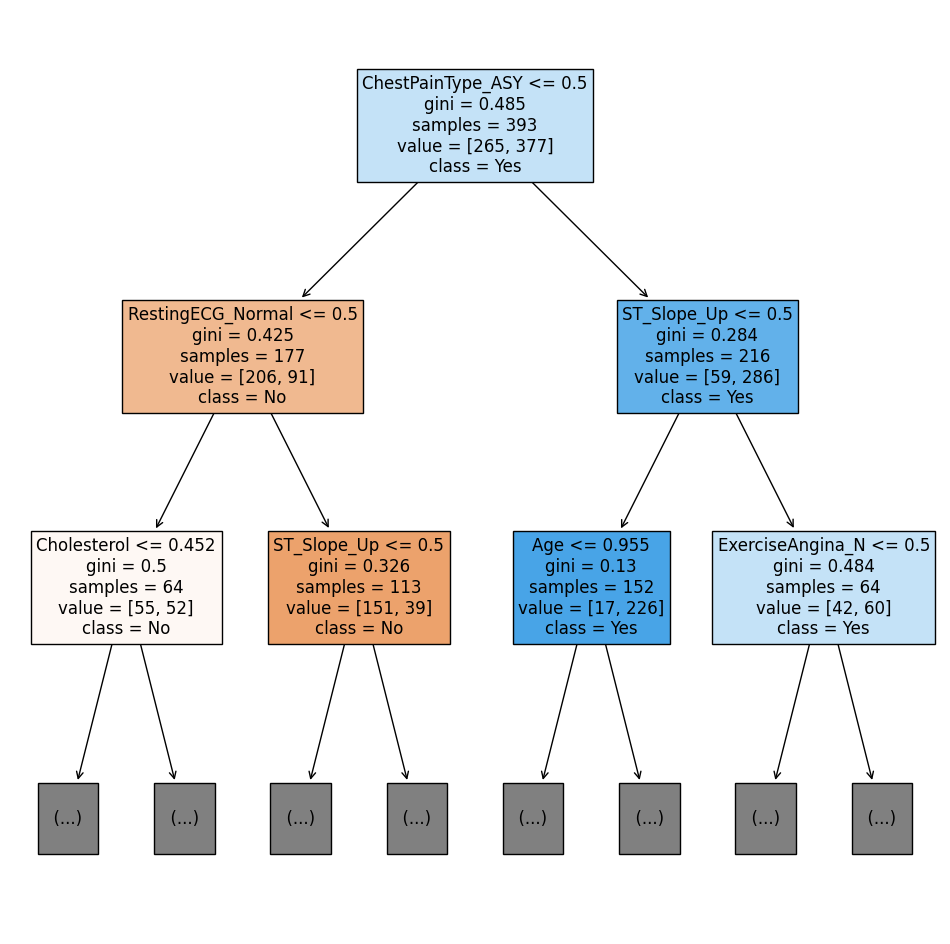

In [62]:
plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
tree.plot_tree(rfc.estimators_[0],
               feature_names = df_preprocessed.columns,
               class_names=["No", "Yes"],
               max_depth=2,
               fontsize=12,
               filled = True);


In [63]:
svc = SVC(kernel='sigmoid', random_state=20)
# Fit the parameters of the classifier with the train data and the actual label (HD yes or no)
svc.fit(x_train, y_train)
# Now the classifier turns into a model, because it has been adjusted in the given data
# Let's see the performance in the test dataset
svc.score(x_test, y_test)

0.8333333333333334

Great! The prediction accuracy has achieved over a 83%. The accuracy is the number of subjects that the model has classified correctly out of the total. But, The model can be improved if we play with the parameters of the classifier.

In [64]:
svc = SVC(kernel='rbf', random_state=20)
# Fit the parameters of the classifier with the train data and the actual label (HD yes or no)
svc.fit(x_train, y_train)
# Now the classifier turns into a model, because it has been adjusted in the given data
# Let's see the performance in the test dataset
svc.score(x_test, y_test)

0.8659420289855072

Changing the kernel of SVC has improved the accuracy in 3 points. The values of the parameters depend on the structure of the input data and the prediction task.

Now, with a random forest, the performance has been improved to a 88% of accuracy (out of 100%).

### 6.2 DL

The neural networks in deep learning are more complexed methods, which benefits from big amounts of data, being able to outperform in many cases ML methods. To know more, see: https://www.coursera.org/specializations/deep-learning?irclickid=0HL3srWYQxyNUsWRyuz6zQy7UkARocV72x5KwY0&irgwc=1&utm_medium=partners&utm_source=impact&utm_campaign=357605&utm_content=b2c&

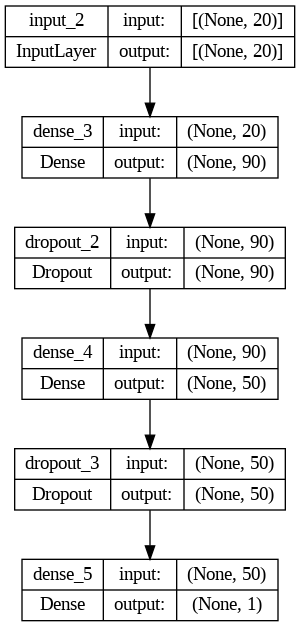

In [65]:
# Create the architecture of the deep learning model
# In the input shape, specify the number of input variables (20 in our case)
X_i = Input(shape=(20))
# Feed forward layer with 40 neurons
X = Dense(90, activation='relu')(X_i)
X = Dropout(0.15)(X)
X = Dense(50, activation='relu')(X)
X = Dropout(0.25)(X)
# The last layer only has 1 neuron, thus, gives one value which is a probability with 'sigmoid'
X = Dense(1, activation='sigmoid')(X)
model = Model(inputs=[X_i], outputs=[X])
# See the architecture
plot_model(model, show_shapes=True, show_layer_names=True)

In the following step we will train the model for 300 epochs (iterations). In the process, the loss and the accuracy are shown. The lost should be decreasing whereas the accuracy increases.

In [66]:
# How to update the parameters of the neural network
adam = Adam(learning_rate=0.01)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics='accuracy')
# Train
history = model.fit(x_train, y_train, epochs=51)

Epoch 1/51
21/21 [==============================] - 7s 7ms/step - loss: 0.4516 - accuracy: 0.8006
Epoch 2/51
21/21 [==============================] - 0s 6ms/step - loss: 0.3778 - accuracy: 0.8583
Epoch 3/51
21/21 [==============================] - 0s 5ms/step - loss: 0.3755 - accuracy: 0.8474
Epoch 4/51
21/21 [==============================] - 0s 7ms/step - loss: 0.3686 - accuracy: 0.8551
Epoch 5/51
21/21 [==============================] - 0s 6ms/step - loss: 0.3622 - accuracy: 0.8660
Epoch 6/51
21/21 [==============================] - 0s 5ms/step - loss: 0.3642 - accuracy: 0.8505
Epoch 7/51
21/21 [==============================] - 0s 7ms/step - loss: 0.3401 - accuracy: 0.8598
Epoch 8/51
21/21 [==============================] - 0s 7ms/step - loss: 0.3358 - accuracy: 0.8660
Epoch 9/51
21/21 [==============================] - 0s 6ms/step - loss: 0.3644 - accuracy: 0.8567
Epoch 10/51
21/21 [==============================] - 0s 6ms/step - loss: 0.3821 - accuracy: 0.8520
Epoch 11/51
21/21 [

In [67]:
model.evaluate(x_test, y_test)

9/9 [==============================] - 1s 4ms/step - loss: 0.3683 - accuracy: 0.8732


[0.36830422282218933, 0.8731883764266968]

<Axes: >

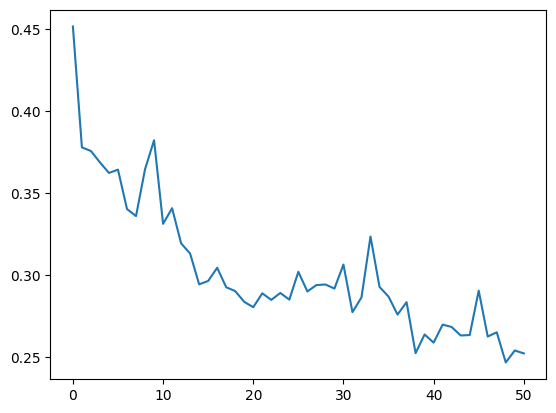

In [68]:
seaborn.lineplot(history.history['loss'])

The accuracy of the nerual network can vary depending the execution. In my case, I have been able to achieve an accuracy of 90%.

In [69]:
# Returns the probability of having heart rate for each of the subjects in the test set
preds = model.predict(x_test)
# We will map each probability to either a 0 or a 1, depending which value is closest
# Although with the ROC curve, the threshold can be fine-tuned
preds = numpy.where(preds > 0.5, 1, 0)
# See first five examples
preds[0:5]

9/9 [==============================] - 0s 3ms/step


array([[1],
       [1],
       [1],
       [1],
       [0]])

## 7. Evaluation

The most common methods for the evaluation of ia models is to print a [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). For that, the actual labels and the predicted ones will be compared.

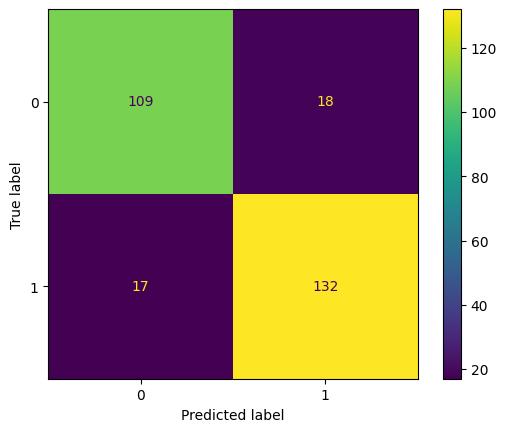

In [70]:
cm = confusion_matrix(y_true=y_test, y_pred=preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In the confusion matrix we can compare the predicted values of the model and the actual values. The columns show how many instances has the model classified as either 0 (i.e. no heart disease) or 1 (i.e. yes heart disease). The diagonal represents the number of subjects that the model has classified correctly (True negatives:TN; True positives: TP), while the inverse diagonal are the mistakes make by the model.

In my case (with a 90% of accuracy), the model has predicted 10 subjects with heart disease, when they do not have (False positives: FP) and 10 subjects with no heart disease when they do have (False negatives: FN). Depending the context of the model, it may be worse to have more FP than FN or viceversa.

From this confusion matrix we can compute several [metrics](https://en.wikipedia.org/wiki/Precision_and_recall), such as accuracy and f1. Accuracy is the most common metric for supervised classification, indicating the proportion of instances ascertained by the model:

accuracy = (TP + TN) / (TP + TN + FP + FN)

In [71]:
accuracy_score(y_test, preds)


0.8731884057971014

In [72]:
# This score also takes into account the FP and FN
f1_score(y_test, preds)

0.8829431438127091

## 8. Visualization

In this example, the visualization will consist in a sensitivity analysis of how each future contributes in the prediction. For that, we will use the shap python package to compute the [shap](https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137#:~:text=SHAP%20values%20(SHapley%20Additive%20exPlanations,interpretability%20of%20machine%20learning%20models.) values, which gets to know the impact in the output probability when the input value of each variable is changed.

In [73]:
# Generate shap explainer with the model and the train data
explainer = shap.DeepExplainer(model, x_train)
# Compute the shap values in the test set
shap_values = explainer.shap_values(x_test)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [74]:
shap.initjs()
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features=df_preprocessed.columns)

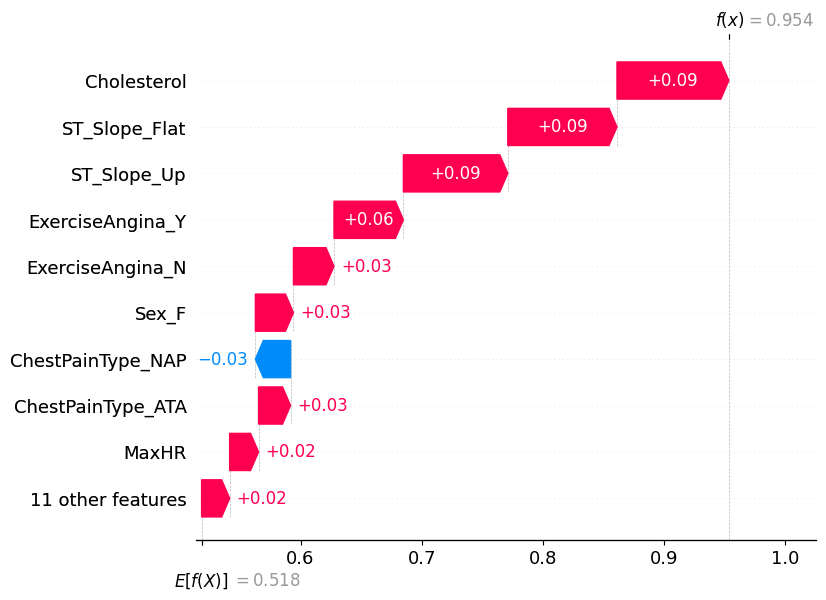

In [75]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0].numpy(), shap_values[0][10], feature_names = df_preprocessed.columns)

In both diagrams, we can see how each input feature affects in the prediction of the likelihood for having a heart disease. For example (depends on the execution), cholesterol can increase the probability of having a heart disease in an 11%.

## Exercise

Throughout this notebook we have seen how to train a model and evaluate it. However, the performance of the model could be improved. For that:

* In section 4: try to get more familiar with the variables and generate more visualization in order to understand the data.

*   In section 6.1:


> *   Use different ML classifiers such as: [KNN](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification), [Naive bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#categorical-naive-bayes), [Logistic Regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) etc. (Don't foget to import the packages at the beginning).
*   Modify the parameters of the classifiers (look into the classifiers documentations).

* In section 6.2:


> *   Modify the number of neurons / dropout (between 0.1 and 1) of each layer.
*   Try to add / remove layers

If you get a better accuracy, run section 8 again to see if there are any changes in the influence of each variable in the output.






## Conclusions

In this notebook we have covered the basic concepts of data exploration and supervised learning with artifical intelligence. Additionally, as shown in the proccess image at the begining, feature selection has not been covered. This step is not essential but may help to improve not only the performance of the model, but also helps to undestand how the model works.